# PBMC scQuint Differential Splicing copy

In [1]:
##Differential intron splicing analysis using scQuint. Scripts by Gonzalo Benegas and Derek Bogdanoff

In [1]:
!date

Tue Sep 10 10:33:18 PDT 2024


In [2]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/scquint_4'

In [3]:
#analysis approach from:
#https://github.com/songlab-cal/scquint/blob/main/differential_splicing_example.ipynb

In [4]:
import anndata

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from scquint.differential_splicing import run_differential_splicing
from scquint.data import calculate_PSI

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from scquint.data import calculate_PSI
from scquint.differential_splicing import run_differential_splicing, run_differential_splicing_for_each_group, find_marker_introns, mask_PSI
from scquint.dimensionality_reduction.pca import run_pca

In [7]:
input_dir = output_dir= '/c4/home/derek/data1/derek/data_scSLR/PBMC/'

In [8]:
#adata_spl = sc.read_h5ad(input_dir+'adata_spl_v2.h5ad')
# adata_spl = sc.read_h5ad(input_dir+'_adata_spl_merged_shared.h5ad')

adata_spl = sc.read_h5ad('./singlets_spl_PBMC_merged_new.h5ad')

adata_spl.obs_names = adata_spl.obs_names.str.replace(pat='-0-22',repl='-0').str.replace(pat='-1-23',repl='-1')

In [9]:
adata_spl

AnnData object with n_obs × n_vars = 19087 × 109539
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'star

In [10]:
adata_exp = sc.read_h5ad(input_dir+'gene_expression_v2.h5ad')
# adata_exp = adata_exp[(adata_exp.obs.batch == '22')]

In [11]:
adata_spl = adata_spl[adata_spl.obs_names.isin(adata_exp.obs_names)]

adata_spl.obs = adata_exp.obs.copy()
adata_spl.obsm['X_umap'] = adata_exp.obsm['X_umap']

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


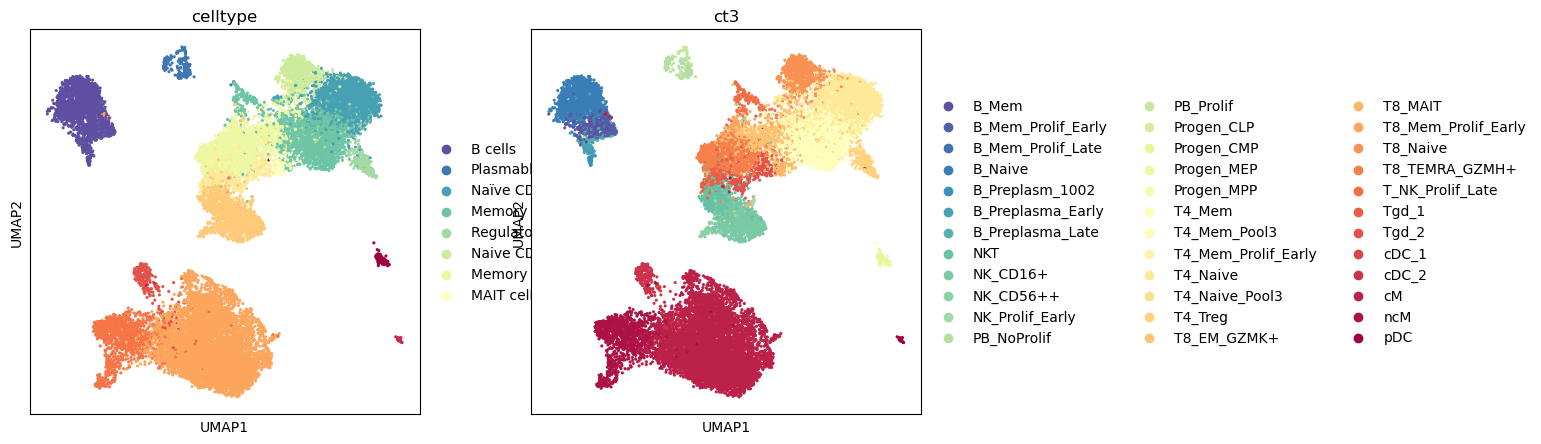

In [12]:
plt.rcParams['figure.figsize'] = 5,5

sc.pl.umap(adata_spl,
           color=['celltype','ct3'],
         #  legend_loc='on data',
           palette='Spectral_r',
           size=20)

In [13]:
groupby = "celltype"
groups_test = adata_spl.obs[groupby].cat.categories
adata_spl.obs[groupby].value_counts()

Classic monocytes               5717
Memory CD4 T cells              2419
Naïve CD4 T cells               2218
Memory CD8 T cells              2052
B cells                         1810
NK cells                        1474
Non-classic monocytes           1136
Naive CD8 T cells                726
γδ T cells                       511
Regulatory CD4 T cells           316
Dendritic cells                  258
Plasmablasts                     186
MAIT cells                       129
Hematopoietic progenitors         90
Plasmacytoid dendritic cells      45
Name: celltype, dtype: int64

In [14]:
# groups_test = [i for i in adata_spl.obs['ct3'].unique() if (i.startswith('T4') | i.startswith('T8'))]

In [15]:
adata_spl[adata_spl.obs.celltype.isin(groups_test)].obs.celltype.value_counts() > 100

Classic monocytes                True
Memory CD4 T cells               True
Naïve CD4 T cells                True
Memory CD8 T cells               True
B cells                          True
NK cells                         True
Non-classic monocytes            True
Naive CD8 T cells                True
γδ T cells                       True
Regulatory CD4 T cells           True
Dendritic cells                  True
Plasmablasts                     True
MAIT cells                       True
Hematopoietic progenitors       False
Plasmacytoid dendritic cells    False
Name: celltype, dtype: bool

In [16]:
# groups_test.remove('T4_Mem_Pool3')
# groups_test.remove('T4_Naive_Pool3')

In [17]:
groups_test

Index(['B cells', 'Plasmablasts', 'Naïve CD4 T cells', 'Memory CD4 T cells',
       'Regulatory CD4 T cells', 'Naive CD8 T cells', 'Memory CD8 T cells',
       'MAIT cells', 'γδ T cells', 'NK cells', 'Classic monocytes',
       'Non-classic monocytes', 'Dendritic cells',
       'Plasmacytoid dendritic cells', 'Hematopoietic progenitors'],
      dtype='object')

In [18]:
adata_spl.obs.columns

Index(['n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS',
       'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well',
       'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor',
       'timepoint', 'respiratory_support_D0', 'onset_to_D0_days',
       'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race',
       'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection',
       'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float',
       'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC',
       'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count',
       'Monocyte_count', 'cell_group', 'exclude_restricted',
       'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score',
       'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2',
       'days_from_start', 'COVID_status', 'admission_level',
       'respiratory_support', 'NIH_clinical', 'COVID_severity',
       'COVID_severity_merged', 'NIH_ordin

In [19]:
# groups_test = adata_spl.obs[groupby].value_counts()[:23].index.values.astype(str).tolist()[:23]

In [20]:
%%time

diff_spl_intron_groups, diff_spl_introns = run_differential_splicing_for_each_group(
    adata_spl, 
    groupby, 
    groups=groups_test,
    subset_to_groups=True,
    min_cells_per_intron_group=10, 
    min_total_cells_per_intron=10, 
    n_jobs=-1,
)

B cells
sample sizes:  1810 17277
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 23000)
Number of intron groups:  9588
Number of introns:  23000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9588/9588 [03:25<00:00, 46.62it/s]


Plasmablasts
sample sizes:  186 18901
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 16240)
Number of intron groups:  6702
Number of introns:  16240


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6702/6702 [02:33<00:00, 43.68it/s]


Naïve CD4 T cells
sample sizes:  2218 16869
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 24374)
Number of intron groups:  10178
Number of introns:  24374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10178/10178 [02:57<00:00, 57.18it/s]


Memory CD4 T cells
sample sizes:  2419 16668
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 28880)
Number of intron groups:  12237
Number of introns:  28880


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12237/12237 [03:51<00:00, 52.82it/s]


Regulatory CD4 T cells
sample sizes:  316 18771
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 9918)
Number of intron groups:  3933
Number of introns:  9918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3933/3933 [02:01<00:00, 32.32it/s]


Naive CD8 T cells
sample sizes:  726 18361
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 15127)
Number of intron groups:  6127
Number of introns:  15127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6127/6127 [02:56<00:00, 34.66it/s]


Memory CD8 T cells
sample sizes:  2052 17035
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 24760)
Number of intron groups:  10349
Number of introns:  24760


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10349/10349 [03:52<00:00, 44.47it/s]


MAIT cells
sample sizes:  129 18958
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 4080)
Number of intron groups:  1571
Number of introns:  4080


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1571/1571 [00:47<00:00, 32.78it/s]


γδ T cells
sample sizes:  511 18576
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 12979)
Number of intron groups:  5223
Number of introns:  12979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5223/5223 [01:53<00:00, 46.12it/s]


NK cells
sample sizes:  1474 17613
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 22643)
Number of intron groups:  9400
Number of introns:  22643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9400/9400 [02:02<00:00, 76.64it/s]


Classic monocytes
sample sizes:  5717 13370
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 31407)
Number of intron groups:  13434
Number of introns:  31407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13434/13434 [02:18<00:00, 96.99it/s]


Non-classic monocytes
sample sizes:  1136 17951
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 24765)
Number of intron groups:  10385
Number of introns:  24765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10385/10385 [02:17<00:00, 75.59it/s]


Dendritic cells
sample sizes:  258 18829
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 16114)
Number of intron groups:  6583
Number of introns:  16114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6583/6583 [01:49<00:00, 59.85it/s]


Plasmacytoid dendritic cells
sample sizes:  45 19042
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 3115)
Number of intron groups:  1192
Number of introns:  3115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1192/1192 [00:35<00:00, 33.18it/s]


Hematopoietic progenitors
sample sizes:  90 18997
(19087, 109539)
filter_min_cells_per_feature
filter_singletons
(19087, 35410)
filter_min_global_proportion
filter_singletons
(19087, 35006)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(19087, 9213)
Number of intron groups:  3736
Number of introns:  9213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3736/3736 [01:15<00:00, 49.74it/s]


CPU times: user 16min 23s, sys: 2min 44s, total: 19min 7s
Wall time: 39min 56s


In [21]:
# diff_spl_intron_groups_orig = diff_spl_intron_groups
# diff_spl_introns_orig = diff_spl_introns

In [22]:
# diff_spl_intron_groups_bac = diff_spl_intron_groups
# diff_spl_introns_bac = diff_spl_introns

In [23]:
# diff_spl_intron_groups = diff_spl_intron_groups_bac
# diff_spl_introns = diff_spl_introns_bac

In [24]:
# diff_spl_intron_groups = pd.read_csv(input_dir+'diff_intron_groups_SLR',index_col=0)

# diff_spl_introns = pd.read_csv(input_dir+'diff_introns_SLR',index_col=0)

In [25]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05')
sig_diff_spl_introns = diff_spl_introns[diff_spl_introns.intron_group.isin(sig_diff_spl_intron_groups.name)]



In [26]:
len(sig_diff_spl_introns.name.unique())

4284

In [24]:
len(sig_diff_spl_introns.name.unique())

4219

In [28]:
len(sig_diff_spl_introns.name.unique())

3729

In [27]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05')
sig_diff_spl_introns = diff_spl_introns[diff_spl_introns.intron_group.isin(sig_diff_spl_intron_groups.name)]

print(f'significant DS intron groups by celltype shape: {sig_diff_spl_intron_groups.shape} \n')

print(f'number of unique significant intron groups: {sig_diff_spl_intron_groups.gene_name.nunique()} \n')

print(f'number of unique significant introns:  {sig_diff_spl_introns.name.unique().shape} \n')

significant DS intron groups by celltype shape: (2413, 12) 

number of unique significant intron groups: 1307 

number of unique significant introns:  (4284,) 



In [28]:
# diff_spl_intron_groups = pd.read_csv(input_dir+'diff_intron_groups_SLR',index_col=0)

# diff_spl_introns = pd.read_csv(input_dir+'diff_introns_SLR',index_col=0)

In [29]:
len(sig_diff_spl_introns.name.unique())

4284

In [30]:
##calculate PSI per batch separately for memory cap 
adatas_spl = {}

for batch in adata_spl.obs.batch.cat.categories:
    adata_batch = adata_spl[adata_spl.obs['batch'] == batch]
    
    adata_batch.layers["PSI_raw"] = calculate_PSI(adata_batch)
    
    adatas_spl[batch] = adata_batch

adata_spl = anndata.concat(adatas_spl, index_unique="-", merge="same")
adata_spl

/c4/home/derek/bin/scquint/scquint/data.py:212: RuntimeWarning: invalid value encountered in divide
  return X / intron_group_sums[:,groups]


AnnData object with n_obs × n_vars = 19087 × 109539
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'star

Text(0.5, 1.0, 'cell counts per celltype')

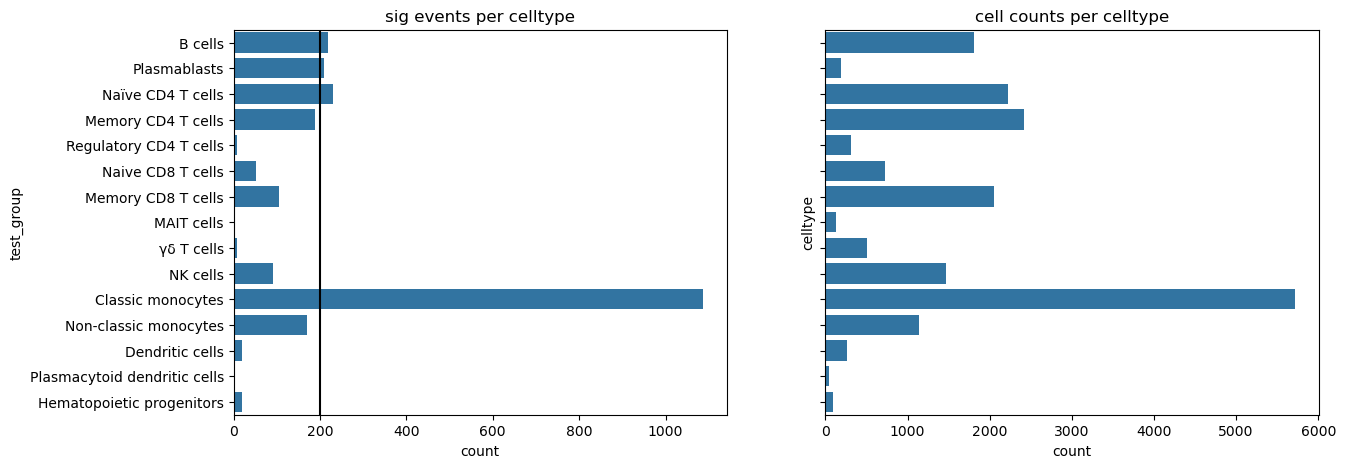

In [33]:
# Number of significant events per cell type
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)


sns.countplot(sig_diff_spl_intron_groups, y="test_group", color="C0", order=groups_test, ax=axes[0])
axes[0].set_title('sig events per celltype')

axes[0].axvline(200, color='k')


sns.countplot(adata_spl.obs, y='celltype', color="C0", order=groups_test, ax=axes[1])
axes[1].set_title('cell counts per celltype')

Text(0.5, 1.0, 'cell counts per celltype')

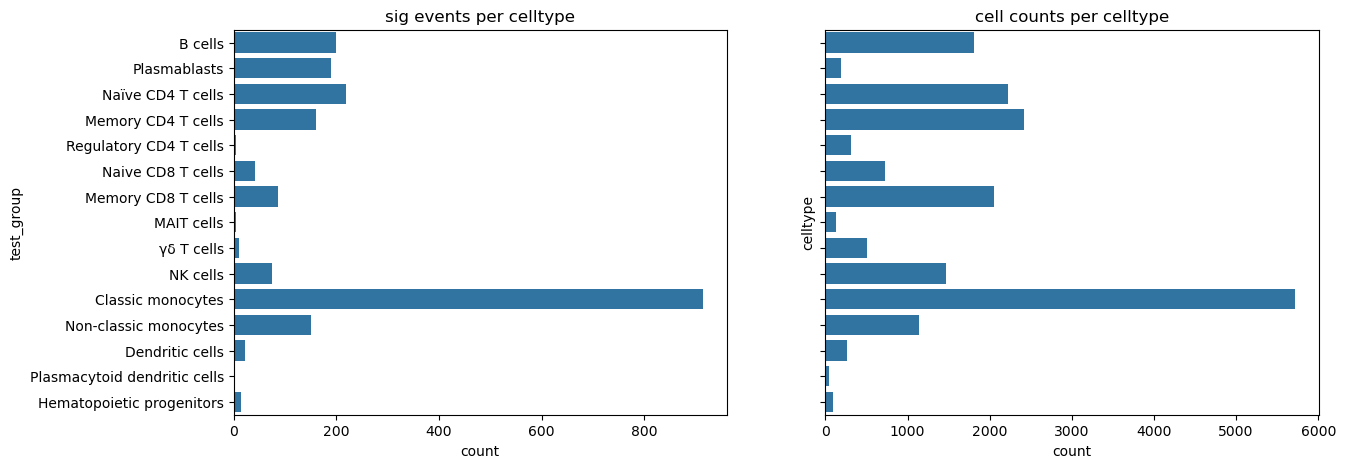

In [31]:
# Number of significant events per cell type
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)


sns.countplot(sig_diff_spl_intron_groups, y="test_group", color="C0", order=groups_test, ax=axes[0])
axes[0].set_title('sig events per celltype')

sns.countplot(adata_spl.obs, y='celltype', color="C0", order=groups_test, ax=axes[1])
axes[1].set_title('cell counts per celltype')

In [34]:
# diff_spl_intron_groups.to_csv('/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_intron_groups_SLR_TCELL')

# diff_spl_introns.to_csv('/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_introns_SLR_TCELL')

In [35]:
marker_introns = find_marker_introns(
    sig_diff_spl_intron_groups, diff_spl_introns, n=10, min_delta_psi=0.2,
)
marker_introns = {c: marker_introns[c] for c in groups_test} # just reordering
marker_introns

{'B cells': ['FOXP1_chr3:71359245-71360479',
  'HSPA4_chr5:133103554-133103864',
  'IGHJ6_chr14:105856218-105863197',
  'PKIG_chr20:44582732-44589796',
  'ADAM28_chr8:24325090-24326553',
  'IGHJ1_chr14:105856218-105865406',
  'IGHJ4_chr14:105856218-105864214',
  'IGHJ5_chr14:105856218-105863813',
  'DENND2D_chr1:111199799-111204295',
  'CENPM_chr22:41939197-41940138'],
 'Plasmablasts': ['NCOA2_chr8:70216765-70216996',
  'PRDM1_chr6:106095735-106099299',
  'ST6GAL1_chr3:186996674-187038741',
  'PTP4A3_chr8:141418019-141421387',
  'CD86_chr3:122078046-122091600',
  'MDM2_chr12:68809087-68809207',
  'CAST_chr5:96702916-96722638',
  'FNDC3A_chr13:48976918-49006151',
  'HDLBP_chr2:241268542-241272760',
  'CREB3L2_chr7:137928367-138001603'],
 'Naïve CD4 T cells': ['AKAP13_chr15:85543956-85575130',
  'SNX29_chr16:12080453-12126632',
  'PRKAR1B_chr7:596305-606192',
  'TARBP1_chr1:234401263-234402215',
  'ARRDC2_chr19:18008585-18008710',
  'PCGF5_chr10:91163082-91222688',
  'DOCK8_chr9:273101-2

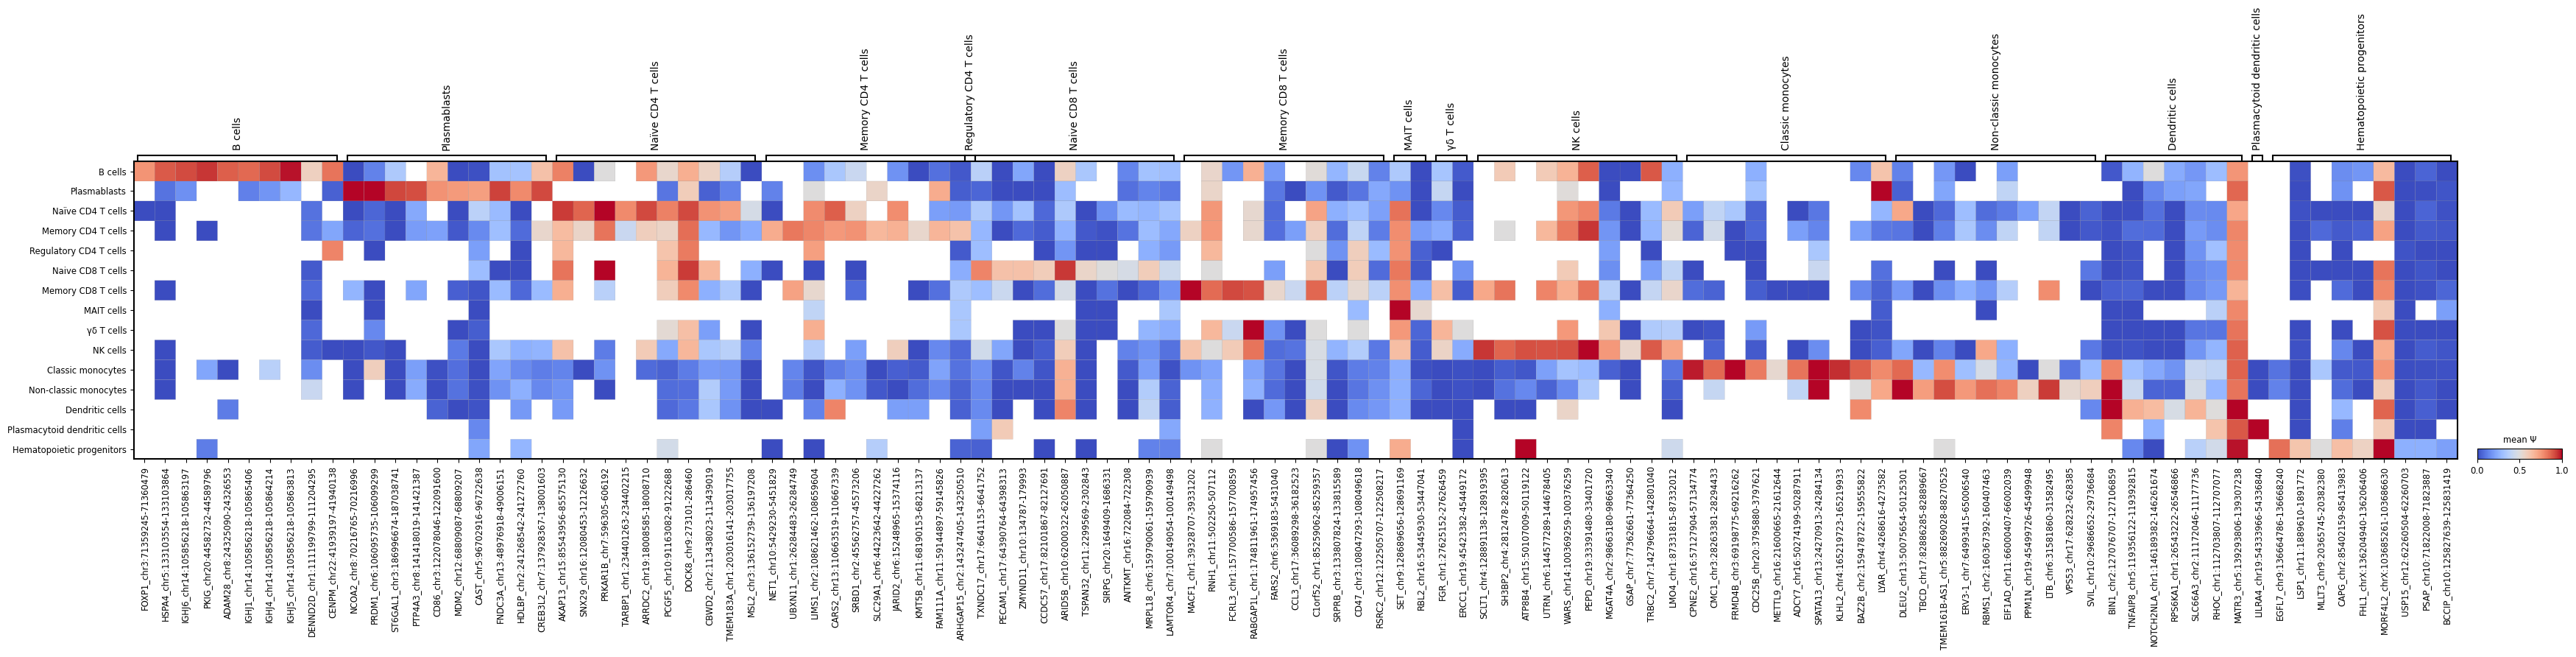

In [36]:
sc.pl.matrixplot(
    mask_PSI(adata_spl[adata_spl.obs[groupby].isin(groups_test)], 
             marker_introns, 
             groupby, min_cells=5),
    marker_introns,
    groupby, 
    cmap='coolwarm',
    categories_order=groups_test,
    swap_axes=False,
    layer="PSI_raw_masked", 
    colorbar_title="mean Ψ",
    vmin=0, vmax=1,
    dendrogram=False,
)

In [41]:
adata_spl.var_names[adata_spl.var_names.str.startswith('GSAP')]

Index(['GSAP_chr7:77311450-77311840', 'GSAP_chr7:77321404-77323646',
       'GSAP_chr7:77329392-77330238', 'GSAP_chr7:77330368-77330805',
       'GSAP_chr7:77353027-77353571', 'GSAP_chr7:77360902-77362112',
       'GSAP_chr7:77362661-77364250', 'GSAP_chr7:77377391-77379846',
       'GSAP_chr7:77397416-77399467', 'GSAP_chr7:77311450-77312100',
       'GSAP_chr7:77321404-77326211', 'GSAP_chr7:77329392-77330181',
       'GSAP_chr7:77353027-77355212', 'GSAP_chr7:77360902-77362582',
       'GSAP_chr7:77362661-77374069', 'GSAP_chr7:77362661-77376847',
       'GSAP_chr7:77311941-77312100', 'GSAP_chr7:77314490-77320724',
       'GSAP_chr7:77314504-77320724', 'GSAP_chr7:77323743-77326211',
       'GSAP_chr7:77329385-77330181', 'GSAP_chr7:77330849-77349350',
       'GSAP_chr7:77337984-77349350', 'GSAP_chr7:77347984-77349350',
       'GSAP_chr7:77349405-77352943', 'GSAP_chr7:77351690-77352943',
       'GSAP_chr7:77353642-77355212', 'GSAP_chr7:77353696-77355212',
       'GSAP_chr7:77355306-7735555

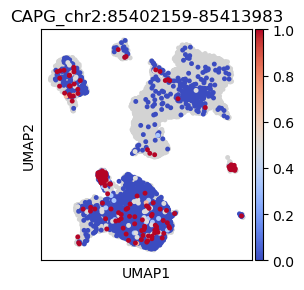

In [56]:
plt.rcParams['figure.figsize'] = 3,3
# Number of significant events per cell type
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sc.pl.umap(adata_spl,
           color= ['CAPG_chr2:85402159-85413983'],
           cmap='coolwarm',
           vmax=1,
           vmin=0,
           size=50,
           layer="PSI_raw",
           sort_order=True,
           ncols=4,
           # ax=ax
          )

In [54]:
intron_list = sig_diff_spl_introns[sig_diff_spl_introns['intron_group'].isin(sig_diff_spl_intron_groups.name)]

len(intron_list.name.unique())

In [55]:
len(intron_list.name.unique())

4219

In [86]:
genedf = sc.get.obs_df(
        adata_spl[adata_spl.obs['celltype'].isin(groups_test)],
        layer = 'PSI_raw',
        keys=["celltype", *intron_list[intron_list['abs_delta_psi'] > .2]['name'].tolist()]
    )
grouped = genedf.groupby("celltype")
mean, var = grouped.mean(), grouped.var()

In [87]:
mean.shape

(15, 3135)

In [88]:
##remove offending gene
mean = mean.loc[:, ~mean.columns.str.startswith('AC092821.3')]

In [89]:
mean.shape

(15, 3131)

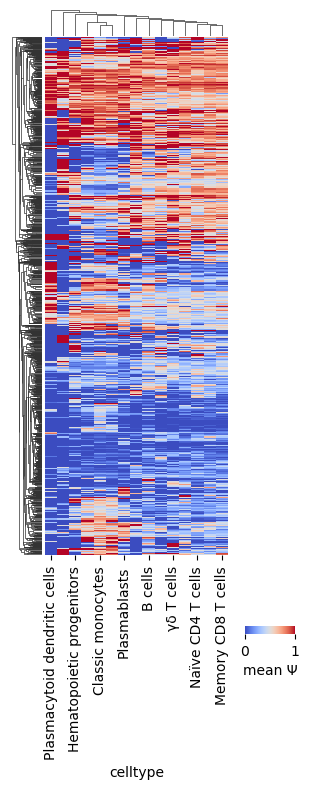

In [90]:
h = sns.clustermap(mean.fillna(0).T,
               cmap="coolwarm",
               figsize=(2.5,8),
               yticklabels=False,
               metric='euclidean',
          #     mask=(np.isinf(mean) |  np.isnan(mean))
               dendrogram_ratio=(.15,.05),
               cbar_pos=(1, .2, .2, .01),
               cbar_kws={'orientation':'horizontal','label':'mean Ψ'}

              )


### plot gene expression for relevant genes

In [ ]:
adata_exp = anndata.read_h5ad("/c4/home/derek/data1/derek/data_scSLR/PBMC/gene_expression.h5ad")
adata_exp

In [ ]:
# genedf_genes = sc.get.obs_df(
#         adata_exp[adata_exp.obs['ct1'].isin(groups_test)],
#       #  layer = 'PSI_raw',
#                     # keys=["ct1", *intron_list[intron_list['abs_delta_psi'] > .20]['name'].tolist()]
#         keys=[x for x in ["ct1", *intron_list[intron_list['abs_delta_psi'] > .20]['gene_name'].tolist()] if x != 'AC092821.3']
#     )
# grouped_genes = genedf_genes.groupby("ct1")
# mean_genes, var_genes = grouped_genes.mean(), grouped_genes.var()

In [ ]:
c = sns.clustermap(mean_genes.fillna(0).T,
               cmap="viridis",
               figsize=(2.5,8),
               yticklabels=False,
          #     metric='euclidean',
          #     mask=(np.isinf(mean) |  np.isnan(mean))
          #     dendrogram_ratio=(0,0),
               row_linkage=h.dendrogram_row.linkage,
               col_linkage=h.dendrogram_col.linkage,
               cbar_pos=(1.02, .2, .2, .01),
               cbar_kws={'orientation':'horizontal','label':'mean\nexpression'},
               z_score=0,
            #   standard_scale=1,
                   # vmax=1,
                   # vmin=-1
              )

c.ax_row_dendrogram.set_visible(False)
c.ax_col_dendrogram.set_visible(False)

In [ ]:
!conda list